# Projet 3 : Concevez une application au service de la santé publique

# Import des données

### Chargement des bibliothèques

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os
sns.set()

## Collab


In [0]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
#répertoir avec nos fichiers
images_dir = "/content/drive/My Drive/data/OPC03"

f_open = images_dir + "/en.openfoodfacts.org.products.csv"


#Import csv in a DataFrame
df = pd.read_csv(f_open
                       , header = 'infer'
                       , sep ="\t"
                        , low_memory=False)
print ('CSV Imported. Shape :')
df_save = df.copy() #keep a copy of original data
df.shape #(1017858 lignes et 175 colonnes)
print("Le jeu de données contient {} lignes et {} colonnes.".format(df.shape[0],df.shape[1]))

CSV Imported. Shape :
Le jeu de données contient 1017858 lignes et 175 colonnes.


##Chargement du fichier de données

In [0]:
path_file = images_dir + "/en.openfoodfacts.org.products.csv"

# Print the size of the final database
print("The size of the initial database is: {} bytes.".format(os.path.getsize(path_file)))

The size of the initial database is: 2096985823 bytes.


Le fichier initial a une taille d'environ 2 Go.


In [0]:
# Loading data
data_raw = pd.read_csv(path_file, # file
                       sep="\t", # separator
                       low_memory=False, # avoid a warning for big files
                      )
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017858 entries, 0 to 1017857
Columns: 175 entries, code to carnitine_100g
dtypes: float64(117), int64(2), object(56)
memory usage: 1.3+ GB


# Propriétés générales de la base de données

The global filling rate of the DataFrame is : 20.77%


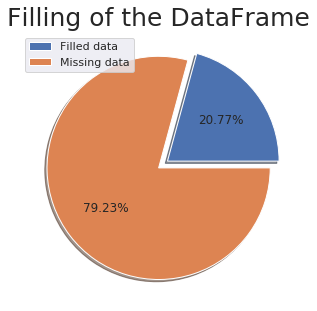

In [0]:
def filling_rate(dataframe):
    """Calcuates and displays the shape of the dataframe and the filling rate"""
    
    # Loading libraries
    import matplotlib.pyplot as plt
    import seaborn as sns
    import math
    
    sns.set()
    
    # get the numbers of rows and columns in the dataframe
    nb_rows, nb_columns = dataframe.shape
    # print("DataFrame has {} rows and {} columns.".format(nb_rows,nb_columns))

    # get the number of non-Nan data in the dataframe
    nb_data = dataframe.count().sum()

    # computing the filling rate
    filling_rate = nb_data / (nb_rows * nb_columns)
    print("The global filling rate of the DataFrame is : {:.2%}".format(filling_rate))
      
    # Setting frequencies and labels for pie plot
    frequencies = [filling_rate, 1 - filling_rate]
    labels = ["Filled data", "Missing data"]
    
    # General informations for the pie plot
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.title("Filling of the DataFrame", fontsize=25)
    ax.axis("equal")
    explode = (0.1, 0)  # only "explode" the 1st slice

    # Plotting pie plot
    ax.pie(frequencies,
           explode=explode,
           # labels=labels,
           autopct='%1.2f%%',
           shadow=True,
          )
    plt.legend(labels)

filling_rate(df)

In [0]:
df.head(5)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,allergens_en,traces,traces_tags,traces_en,...,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,NaN,130 g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00000000001111111111,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1560020173,2019-06-08T18:56:13Z,1560020173,2019-06-08T18:56:13Z,Sfiudwx,NaN,dgesc,NaN,NaN,Watt,watt,fr:Xsf,fr:xsf,fr:xsf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:France,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000000123,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1535737982,2018-08-31T17:53:02Z,1535737986,2018-08-31T17:53:06Z,Sauce Sweety chili 0%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0000000000178,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1542456332,2018-11-17T12:05:32Z,1542456333,2018-11-17T12:05:33Z,Mini coco,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Chaque colonne correspond à une variable (feature), et chaque ligne correspond à un produit.

Nous voyons que sur les premières lignes au moins, de nombreuses données sont manquantes. Ces données manquantes sont indiquées par NaN.

# Sélection des colonnes

In [0]:
# List of names of the columns
print("Names of the columns :", list(df))

Names of the columns : ['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'product_name', 'generic_name', 'quantity', 'packaging', 'packaging_tags', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_en', 'origins', 'origins_tags', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_en', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'stores', 'countries', 'countries_tags', 'countries_en', 'ingredients_text', 'allergens', 'allergens_en', 'traces', 'traces_tags', 'traces_en', 'serving_size', 'serving_quantity', 'no_nutriments', 'additives_n', 'additives', 'additives_tags', 'additives_en', 'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 'nutrition_grade_f

Comme indiqué dans l'appel à projet, les champs sont séparés en sections. Mais selon le descriptif des données sur le site  [openfoodfacts.org](https://world.openfoodfacts.org/data/data-fields.txt), il y a 5 sections. Nous remarquons aussi certaines variations dans les intitulés des colonnes, et quelques colonnes supplémentaires.

1. "*general informations*" : les informations générales sur la fiche du produit
   * de la colonne 'code'…
   * … à la colonne 'quantity'
2. "*tags*" : un ensemble de tags
   * de la colonne 'packaging'…
   * … à la colonne 'countries_en'
3. "*ingredients*": les ingrédients et additifs éventuels.
   * de la colonne 'ingredients_text'…
   * … à la colonne 'traces_en'
4. "*misc. data*" : des informations diverses
   * de la colonne 'serving_size'…
   * … à la colonne 'image_nutrition_small_url'
5. "*nutrition facts*" : des informations nutritionnelles
   * de la colonne 'energy_100g'…
   * … à la colonne 'carnitine_100g'



## Élimination des colonnes remplies à moins de 15%
Nous faisons une fonction pour éliminer les variables (colonnes) dont le taux de remplissage est inférieur à un seuil.
Le seuil de 15% a été choisit car les colonnes décrite ne prensente pas d'informations qui seront utiliser dans la suite de mon analyse et car cela permet de reduire la base de donnée final

In [0]:
def fillingrate_filter_columns(dataframe, limit_rate):
    """This function drop the colums where the filling rate is less than a defined limit rate."""

    # Count of the values on each column
    columns_count = dataframe.count()

    # Number of rows in the dataframe
    nb_rows = dataframe.shape[0]
    
    # Calculating filling rates
    filling_rates = columns_count / nb_rows

    # Define a mask of features with a filling_rate bigger than the limit rate
    mask = filling_rates > limit_rate
    
    # Apply the mask to the filling_rates Series
    filling_rates_selection = filling_rates[mask]
    
    # Get the list of the name of the selected columns
    features_selection = list(filling_rates_selection.index)
    print("Number of columns with a filling rate bigger than  {:.15%} : {} columns.".format(limit_rate, len(features_selection)))

    # Return a projection on the selection of features
    return dataframe[features_selection]

In [0]:
data_cleaned = fillingrate_filter_columns(data_cleaned, 0.15)

# Transtypage des données

### Variables temporelles

In [0]:
# List of date and time features
datetime_features = [
    'created_datetime',
    'last_modified_datetime',
    'created_t',
    'last_modified_t',
]

# Converting the date and time features
for feature in datetime_features:
    df[feature] = pd.to_datetime(df[feature])

### Variables catégorielles nominales

In [0]:
# List of nominal features
nominal_features = [
    'categories',
    'categories_tags',
    'categories_en',
]

# Converting the dtype for nominal features
for feature in nominal_features:
    df[feature] = df[feature].astype('category')

### Variables catégorielles ordinales

In [0]:
# List of ordinal features
ordinal_features = [
    'nova_group',
    'nutrition_grade_fr',
]

# Converting the dtype of ordinal features
from pandas.api.types import CategoricalDtype

for feature in ordinal_features:
    df[feature] = df[feature].astype(CategoricalDtype(ordered=True))

In [0]:
def piechart_dtypes(dataframe):
    """Plot a piechart of dtypes of features in the dataframe"""
    
    # Loading libraries
    import matplotlib.pyplot as plt
    
    # get the list of the dtypes in the dataframe
    dtypes_count = dataframe.get_dtype_counts() 
    # Should use : dtypes_count = dataframe.dtypes.value_counts()
    # Fix : dtypes_count = df.dtypes.astype(str).value_counts()

    # Set frequencies and labels
    labels = dtypes_count.index.values
    frequencies = dtypes_count.values

    # General informations for the pie plot
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.title("Types of features", fontsize=25)
    ax.axis("equal")

    # Plotting pie plot
    ax.pie(frequencies,
            # labels=labels,
            autopct='%1.2f%%',
            shadow=True,
              )
    plt.legend(labels)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: `get_dtype_counts` has been deprecated and will be removed in a future version. For DataFrames use `.dtypes.value_counts()
  


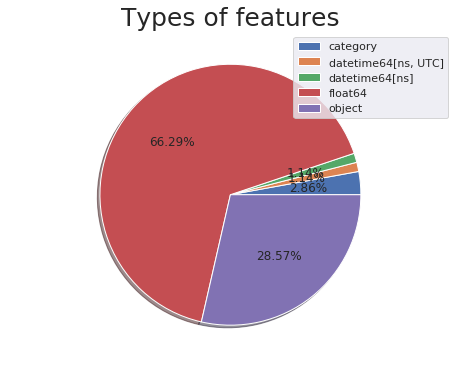

In [0]:
dataframe = df
piechart_dtypes(df)

## Élimination des colonnes non-pertinentes pour le projet

In [0]:
df.shape

(1017858, 175)

In [0]:
# List of columns to drop
columns_useless = [
    'url',
    'creator',
    'image_url',
    'image_small_url',
    'image_ingredients_url',
    'image_ingredients_small_url',
    'image_nutrition_url',
    'image_nutrition_small_url',
    
    'created_datetime',
    'last_modified_datetime',
    'created_t',
    'last_modified_t',
    
    # Suppression des COLONNES en doublons portant la même information:
    'states',
    'states_tags',
    'states_en',
    'packaging',
    'packaging_tags',
    'brands',
    'brands_tags', 
    'categories', 	
    'categories_tags', 
    'labels',
    'labels_tags',
    'purchase_places',
    'stores', 
    'countries',
    'countries_tags',
    'main_category'

]

# Droping useless columns
data_cleaned = df.drop(columns=columns_useless)
data_cleaned.shape

(1017858, 147)

In [0]:
# Suppression COLONNE 'nutrition-score-uk_100g': on utilise 'nutrition-score-fr_100g'
data_cleaned = data_cleaned.drop('nutrition-score-uk_100g', axis='columns')


In [0]:
# Filtre sur les produits vendus en France:
data_cleaned = data_cleaned[data_cleaned['countries_en'].notna()] #suppr. NaN
data_cleaned = data_cleaned[data_cleaned['countries_en'].str.lower().str.contains("france")] #filtre France
data_cleaned.shape

(615106, 146)

Permet de suprimmer environ 400K ligne

# Gestion des doublons (code-barres) : fusion
Nous allons nettoyer les doublons (code-barres identiques).

In [0]:
def number_duplicates(dataframe, subset):
    """This function displays and return the number of duplicate in a dataset,
    based on a subset of columns."""
    
    # Marking all duplicates
    duplicates = dataframe.duplicated(subset=subset, keep=False)
    
    # If there are duplicated rows
    if True in list(duplicates.unique()):
        
        # Display and return number of duplicated rows
        result = len(dataframe[duplicates])
        print("There are {} duplicated rows.".format(result))
        return result
    
    # If there are no duplicated rows
    else:
        print("There are no duplicated rows.")
        return 0

Nous définissons une fonction pour fusionner les doublons.

In [0]:
def duplicates_merging(dataframe,subset):
    """This function handles duplicates rows in the dataframe, based on a subset of columns (features)."""
    
    # Checking if there are some duplicated rows
    duplicates_mask = dataframe.duplicated(subset=subset, keep=False)
    if True not in list(duplicates_mask.unique()):
        print("No duplicates.")
        return dataframe
    
    print("Number of duplicates rows :", len(dataframe[duplicates_mask]))
    
    # Filtering the dataframe to keep only duplicated rows
    duplicates_mask = dataframe.duplicated(subset=subset, keep=False)
    duplicates_df = dataframe[duplicates_mask]

    # Group-by subset of columns used for key, sort=False to speed-up
    gb = duplicates_df.groupby(subset, sort=False)

    # Initializing aggregated dataframe
    agg_df = pd.DataFrame()

    # Identification of numerical and non-numerical columns
    numeric_columns = list(dataframe.select_dtypes(include=[np.number]).columns.values)

    # defining aggregation function for non-numerical columns
    def agg_mode(x): m = pd.Series.mode(x); return m.values[0] if not m.empty else np.nan

    # Iterating upon columns
    for column in dataframe.columns:

        # Calculate the mean of each group for numeric columns
        if column in numeric_columns:
            agg_col = gb[column].agg('mean')

        # Calculate the mode of each group for numeric columns
        else:
            agg_col = gb[column].agg(agg_mode)
            
        # adding the aggregated column to aggregated dataframe
        agg_df = pd.concat([agg_df, agg_col], axis=1, sort=True)

    # Dropping all duplicates
    dataframe_cleaned = dataframe.drop_duplicates(subset=subset, keep=False)

    # Concatenating the dataframe without duplicates and the aggregated rows for duplicates
    result = dataframe_cleaned.append(agg_df, ignore_index=True, sort=False)

    print("Shape after handling duplicates :", result.shape)
    return result

In [0]:
dataframe = data_cleaned
subset = ['code']

data_cleaned = duplicates_merging(dataframe,subset)

Number of duplicates rows : 188
Shape after handling duplicates : (615012, 146)


#Valeur aberante


##valeur trop grande ou trop petite

In [0]:
cols_100g = ['fat_100g', "saturated-fat_100g",  "trans-fat_100g", "cholesterol_100g", "carbohydrates_100g", "sugars_100g", "fiber_100g", "proteins_100g", "salt_100g", "sodium_100g", "vitamin-a_100g", "vitamin-c_100g", "calcium_100g", "iron_100g"]

for cols in cols_100g:
  #valeur trop grande
  data_cleaned.loc[data_cleaned[cols] > 100, cols] = np.nan
  #valeur trop petite
  data_cleaned.loc[data_cleaned[cols] < 0, cols] = np.nan

In [0]:

data_cleaned[cols_100g].describe()

,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g
count,494531.000000,495653.000000,1609.000000,1606.000000,494321.000000,495912.000000,123987.000000,497133.000000,482983.000000,482984.000000,1972.000000,3134.000000,5621.00000,3035.000000
mean,13.905753,5.349466,0.076353,0.077709,27.451772,13.964068,2.991499,8.636190,1.308167,0.522905,0.096245,0.223746,0.37787,0.039026
std,17.327200,7.965004,0.465959,1.286575,27.867367,20.181557,5.372979,9.792544,4.934851,1.977896,2.809186,3.123956,3.47945,0.433506
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,1.000000,0.200000,0.000000,0.000000,2.850000,0.700000,0.000000,1.400000,0.060000,0.024000,0.000000,0.000000,0.07000,0.001200
50%,7.600000,2.000000,0.000000,0.000000,14.000000,3.700000,1.600000,6.000000,0.500000,0.200000,0.000070,0.014000,0.12000,0.003200
75%,22.000000,7.800000,0.000000,0.002000,53.000000,20.000000,3.600000,12.000000,1.300000,0.520000,0.000240,0.029000,0.23570,0.007000
max,100.000000,100.000000,14.060000,32.000000,100.000000,100.000000,100.000000,100.000000,100.000000,67.000000,100.000000,100.000000,100.00000,11.100000


##valeur parent


Ici l'on vas nétoyer les valeurs "enfants" par rapport au valeur parente. en effet la somme des premieres doit étre inferieur a la veleur de la seconde.

####Fat



In [0]:
cols_fat= ["saturated-fat_100g", "trans-fat_100g", "cholesterol_100g"]

data_cleaned.loc[data_cleaned[cols_fat].sum(axis=1) > data_cleaned['fat_100g'], cols_fat] = np.nan

In [0]:
data_cleaned[cols_fat].sum(axis=1).describe()

count    615012.000000
mean          4.308384
std           7.449612
min           0.000000
25%           0.000000
50%           0.900000
75%           5.600000
max         100.000000
dtype: float64

###Carbo


In [0]:
cols_carbo= ["sugars_100g", "fiber_100g"]
data_cleaned.loc[data_cleaned[cols_carbo].sum(axis=1) > data_cleaned["carbohydrates_100g"], cols_fat] = np.nan

In [0]:
data_cleaned[cols_fat].sum(axis=1).describe()

count    615012.000000
mean          4.127578
std           7.323242
min           0.000000
25%           0.000000
50%           0.700000
75%           5.100000
max         100.000000
dtype: float64

##somme quantité = 100

In [0]:
cols_100g_nutriments= ['fat_100g', "carbohydrates_100g", "proteins_100g", "salt_100g", "sodium_100g", "vitamin-a_100g", "vitamin-c_100g", "calcium_100g", "iron_100g"]
data_cleaned.loc[data_cleaned[cols_100g_nutriments].sum(axis=1) > 100, cols_100g_nutriments] = np.nan

In [0]:
data_cleaned[cols_100g_nutriments].sum(axis=1).describe()

count    615012.000000
mean         40.796981
std          34.652849
min           0.000000
25%           6.168000
50%          34.600000
75%          76.820500
max         100.000000
dtype: float64

##valeur énergetique


In [0]:
#valeur énergetique max de 900 
data_cleaned.loc[data_cleaned["energy_100g"] > 900, ["energy_100g"]] = np.nan
data_cleaned.loc[data_cleaned["energy_100g"] < 0, ["energy_100g"]] = np.nan

In [0]:
data_cleaned["energy_100g"].describe()

count    209125.000000
mean        396.933486
std         263.320403
min           0.000000
25%         176.000000
50%         384.000000
75%         615.000000
max         900.000000
Name: energy_100g, dtype: float64

# Calcul du taux de remplissage par feature

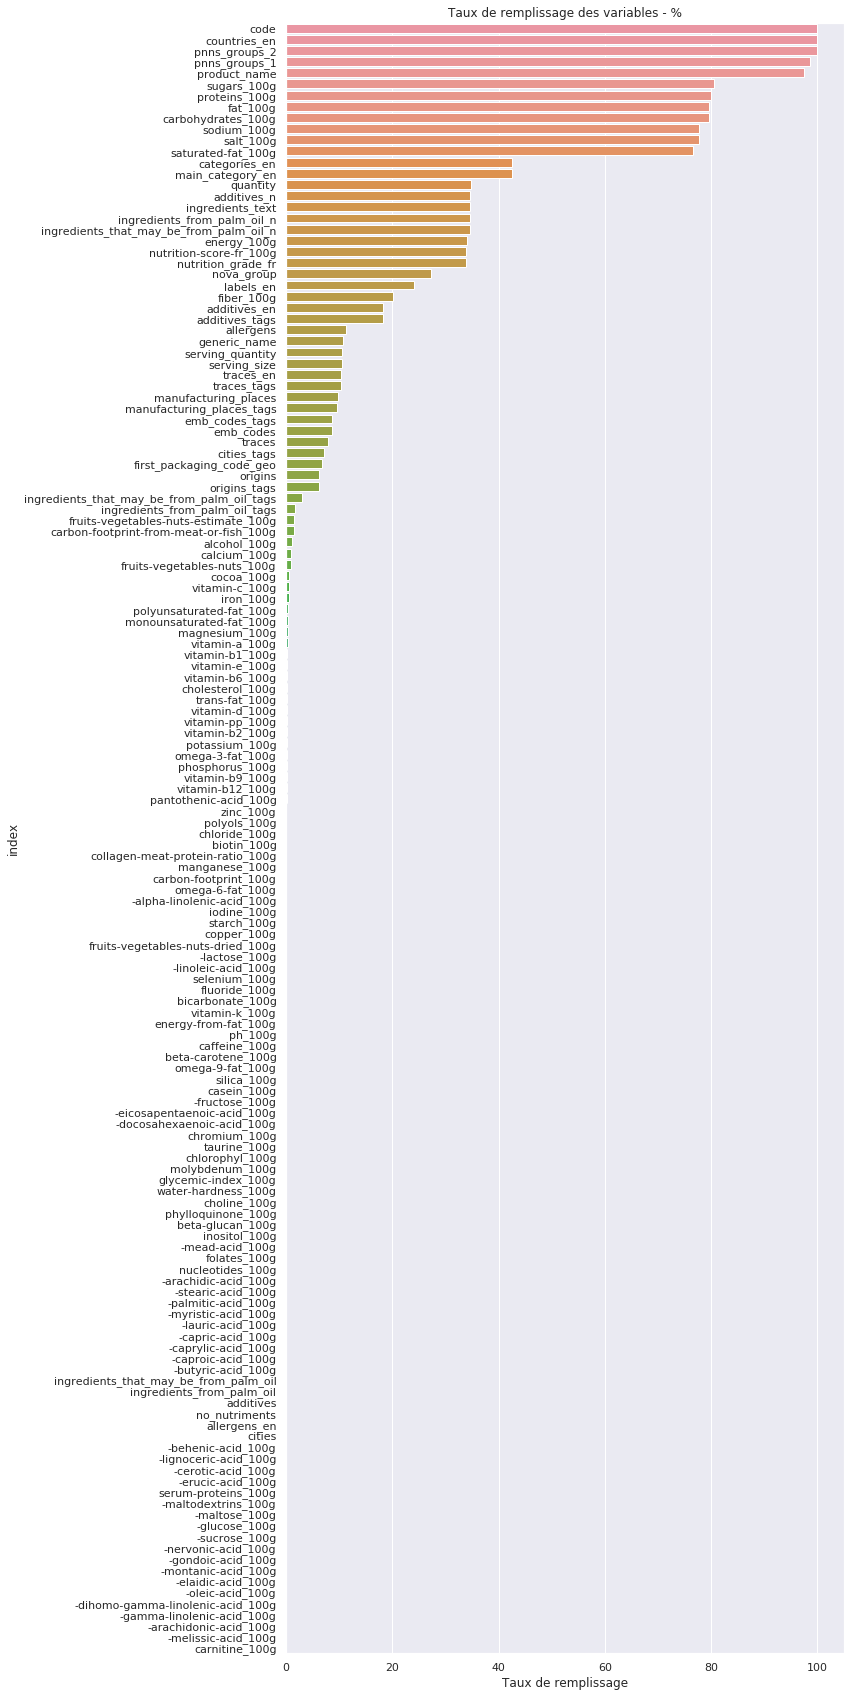

In [0]:
# Calcul du taux de remplissage des colonnes:
df = pd.DataFrame(round(data_cleaned.count(axis=0)/data_cleaned.shape[0]*100,2),
             columns=['Taux de remplissage']).sort_values('Taux de remplissage',
                                                          ascending=False).reset_index()
fig, ax = plt.subplots(figsize=(10,30))
sns.barplot(y=df['index'],
             x='Taux de remplissage',
             data=df,
           )
plt.title('Taux de remplissage des variables - %')
plt.show()


In [0]:
nb_rows, nb_columns = data_cleaned.shape

# Count of the values on each column
columns_count = data_cleaned.count()

# Sort the Series
columns_count = columns_count.sort_values(ascending=False)

# Calculating filling rates
filling_rates = columns_count / nb_rows

# Display a sampling (1 out of 10) of columns names and filling rates
filling_rates[::10]

code                       1.000000
sodium_100g                0.777733
nutrition-score-fr_100g    0.338595
serving_size               0.104637
origins                    0.061878
vitamin-c_100g             0.005018
cholesterol_100g           0.002250
zinc_100g                  0.000950
copper_100g                0.000423
ph_100g                    0.000167
chromium_100g              0.000052
beta-glucan_100g           0.000023
-montanic-acid_100g        0.000002
cities                     0.000000
-myristic-acid_100g        0.000000
dtype: float64

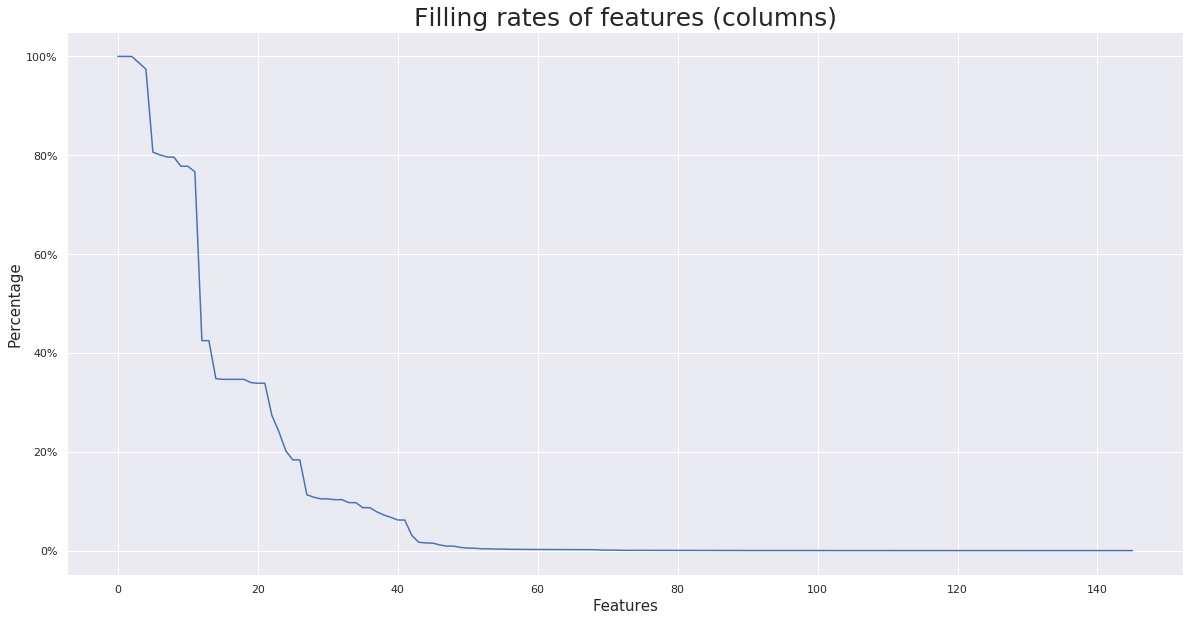

In [0]:
# Plot chart of the filling_rates
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set()

x = range(nb_columns)
y = filling_rates

fig, ax = plt.subplots(figsize=(20, 10))
plt.title("Filling rates of features (columns)", fontsize=25)
plt.xlabel("Features", fontsize=15)
plt.ylabel("Percentage", fontsize=15)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
plot = ax.plot(x, y)

Nous constatons que quelques colonnes sont intégralement remplis.

Nous constatons aussi que de nombreuses colonnes sont très faiblement ou pas du tout remplies. Ainsi, environ une centaine d'indicateurs (sur les 160 que contient encore la table) ont un remplissage inférieur à 5%.




# Nettoyage des lignes

## Filtrage sur le code-barres EAN-13 (colonne 'code')
La documentation du site  [openfoodfacts.org](https://world.openfoodfacts.org/data/data-fields.txt) précise : "*code : barcode of the product (can be EAN-13 or internal codes for some food stores), for products without a barcode, Open Food Facts assigns a number starting with the 200 reserved prefix*".

Nous n'allons toutefois, en raison de notre application, ne garder que les lignes avec un code-barres EAN-13 valide.

In [0]:
def check_key(barcode):
    """This function check the control key (last digit) of the 13-digits barcode."""
    
    # Import of regular expressions module
    import re

    # Definition of regular expression : 13 digits only
    regex = "^\d{13}$"

    # Compilation of regular expression
    pattern = re.compile(regex)
    
    # Return False if the code does not fit regular expression
    if pattern.match(str(barcode))==None:
        return False
    
    # conversion to string to iterate on digits
    barcode_str = str(barcode)
    
    # getting the last digit
    last_digit = int(barcode_str[-1:])
    
    # removing last digit from barcode
    barcode_str = barcode_str[:-1]
    
    # initialisation of the control sum
    sum = 0  
    
    # for each digit in the barcode
    for index, digit in enumerate(barcode_str):
        digit = int(digit) # conversion back as integer
        
        # if index is an even number (digits of rank 1, 3, 5…)
        if index % 2 == 0:
            # adding to the sum with a ponderation of 1
            sum += 1*digit
        
        # if index is an odd number (digits of rank 2, 4, 6…)
        else :
            # adding to the sum with a ponderation of 1
            sum += 3*digit
    
    # computing the control key with division of the key by 10
    rest = sum % 10
    if rest == 0 :
        key = 0
    else:
        key = 10 - rest
    
    # compare control key and last digit of the barcode
    if key == last_digit:
        return True
    else:
        return False

In [0]:
# Matching the pattern in the column 'code' on each line of the DataFrame
mask = [check_key(code) for code in data_cleaned['code']]

# Dropping the rows with non-compliant EAN-13 code
data_cleaned = data_cleaned[mask]
print("Number of rows in the cleaned data:", data_cleaned.shape[0])

Number of rows in the cleaned data: 573321


Le filtrage a permis de nettoyer environ 30'000.
avant 599022


## Correction pour le 'pnns_groups_1': suppression '-' et mise en majuscule:


In [0]:
# Correction pour le 'pnns_groups_1': suppression '-' et mise en majuscule:
data_cleaned['pnns_groups_1'] = data_cleaned['pnns_groups_1'].str.replace('-',' ').str.capitalize()

# Imputation pour les lignes ayant un nom de produit identique
Pour ces lignes qui possèdent le même nom de produit, nous n'allons pas "supprimer ni fusionner les doublons" mais utiliser le champ 'product_name' comme clé pour faire de l'imputation. En effet, il est important pour notre application de conserver tous les codes-barres correspondant à un produit.

In [0]:
dataframe = data_cleaned
subset = ["product_name"]

number_duplicates(dataframe, subset)

There are 218800 duplicated rows.


218800

In [0]:
def imputation(dataframe, feature, keys):
  #encour k voisin 
    """This function impute substitute values for missing values for a specific column (feature),
    based on other rows sharing some properties (values on other fields of subset).
    Also add a new feature to inform if the value was imputed.
    Does only handle numeric features yet."""
    
    # Identify NaN values pre-imputation
    mask_before = dataframe[feature].isnull()
    
    # Copying the dataframe to avoid manipulating a slice
    result = dataframe.copy()
    
    # Initialize column for imputed values if doesn't exist
    if "imputed_" + feature not in result.columns:
        result["imputed_" + feature] = False
    
    # Iterating on each feature in the subset
    for column in keys:
        
        # Grouping the DataFrame on the column's value, sort=False to speed-up
        grouped = dataframe.groupby(column, sort=False)
        
        # Computing the mean of feature for each group
        means_of_group = grouped[feature].transform('mean') # to adapt for object and categorical dtypes features
        
        # Filling missing values with the mean of each group
        result[feature].fillna(value=means_of_group, axis=0, inplace=True)
    
    # Identify NaN values post-imputation
    mask_after = result[feature].isnull()
    
    # Values imputed : boolean symetric difference
    mask_imputed = mask_after ^ mask_before
    
    # Update the column to inform that the feature was imputed
    result.loc[:,"imputed_" + feature][mask_imputed] = True # raise a SettingWithCopyWarning
    
    return result

### Avant l'imputation

The global filling rate of the DataFrame is : 56.29%


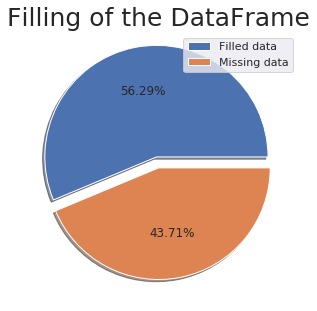

In [0]:
dataframe = data_cleaned

# Before imputation
filling_rate(dataframe)

In [0]:
# Ordered list of the keys used to impute the feature
keys = ['product_name']

# Selection of numeric columns with high enough filling rate
numeric_columns = data_cleaned.select_dtypes(include=['number']).columns

# Selection of columns to apply
mask = filling_rates > 0.75
filled_columns = list(filling_rates[mask].index)

# Intersection of the two sets (numeric and filling rate)
columns_to_impute = list(set(numeric_columns) & set(filled_columns))

# Features to impute : numerical columns (barcode is an object column)
for feature in columns_to_impute:
    
    # Proceed to imputation
    data_cleaned = imputation(dataframe, feature, keys)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Après l'imputation

The global filling rate of the DataFrame is : 58.08%


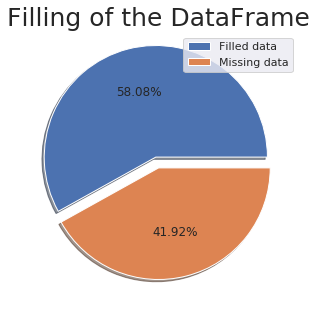

In [0]:
dataframe = data_cleaned

# After imputation
filling_rate(dataframe)

In [0]:
# Suppression des LIGNES sans nom de produit:
data_cleaned = data_cleaned[data_cleaned['product_name'].notnull()]
data_cleaned.shape

(560301, 28)

##  Imputation des valeurs numériques manquantes


Nous sélectionnons les colonnes numériques ayant un taux de remplissage suffisant (> 75 %).

### Identification des colonnes remplies à plus de 75%


In [0]:
mask = filling_rates > 0.75
filling_rates[mask]

code                  1.000000
countries_en          1.000000
pnns_groups_2         0.999717
pnns_groups_1         0.987046
product_name          0.974001
sugars_100g           0.806345
proteins_100g         0.800682
fat_100g              0.796458
carbohydrates_100g    0.796118
salt_100g             0.777736
sodium_100g           0.777733
saturated-fat_100g    0.766338
dtype: float64

Les champs remplis à 100% correspondent vraissemblablement à des champs obligatoires (sur le formulaire de remplissage, ou pour l'enregistrement dans la base de données) ou à de données générées automatiquement (timestamps par exemple) lors de l'ajout d'un produit dans la base de données.

### Imputation pour les colonnes remplies à plus de 75%
Nous appliquons l'[imputateur multivarié expérimental](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer) de scikit-learn.

In [0]:
# The iterative imputer requires version 0.21.2 of scikit-learn
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.22.1.


In [0]:
# Load libraries
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Selection of numeric columns with high enough filling rate
numeric_columns = data_cleaned.select_dtypes(include=['number']).columns

# Selection of columns to apply
mask = filling_rates > 0.75
filled_columns = list(filling_rates[mask].index)

# Intersection of the two sets (numeric and filling rate)
columns_to_impute = list(set(numeric_columns) & set(filled_columns))

# Instanciation of iterative imputer
imp = IterativeImputer(max_iter=10, random_state=0)

# Train and apply (inplace) the iterative imputer
data_cleaned[columns_to_impute] = imp.fit_transform(data_cleaned[columns_to_impute])

/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


##Resumer

The global filling rate of the DataFrame is : 63.45%


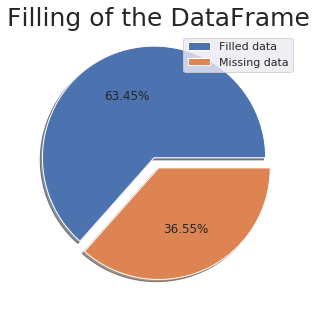

In [0]:
dataframe = data_cleaned

# After imputation
filling_rate(dataframe)

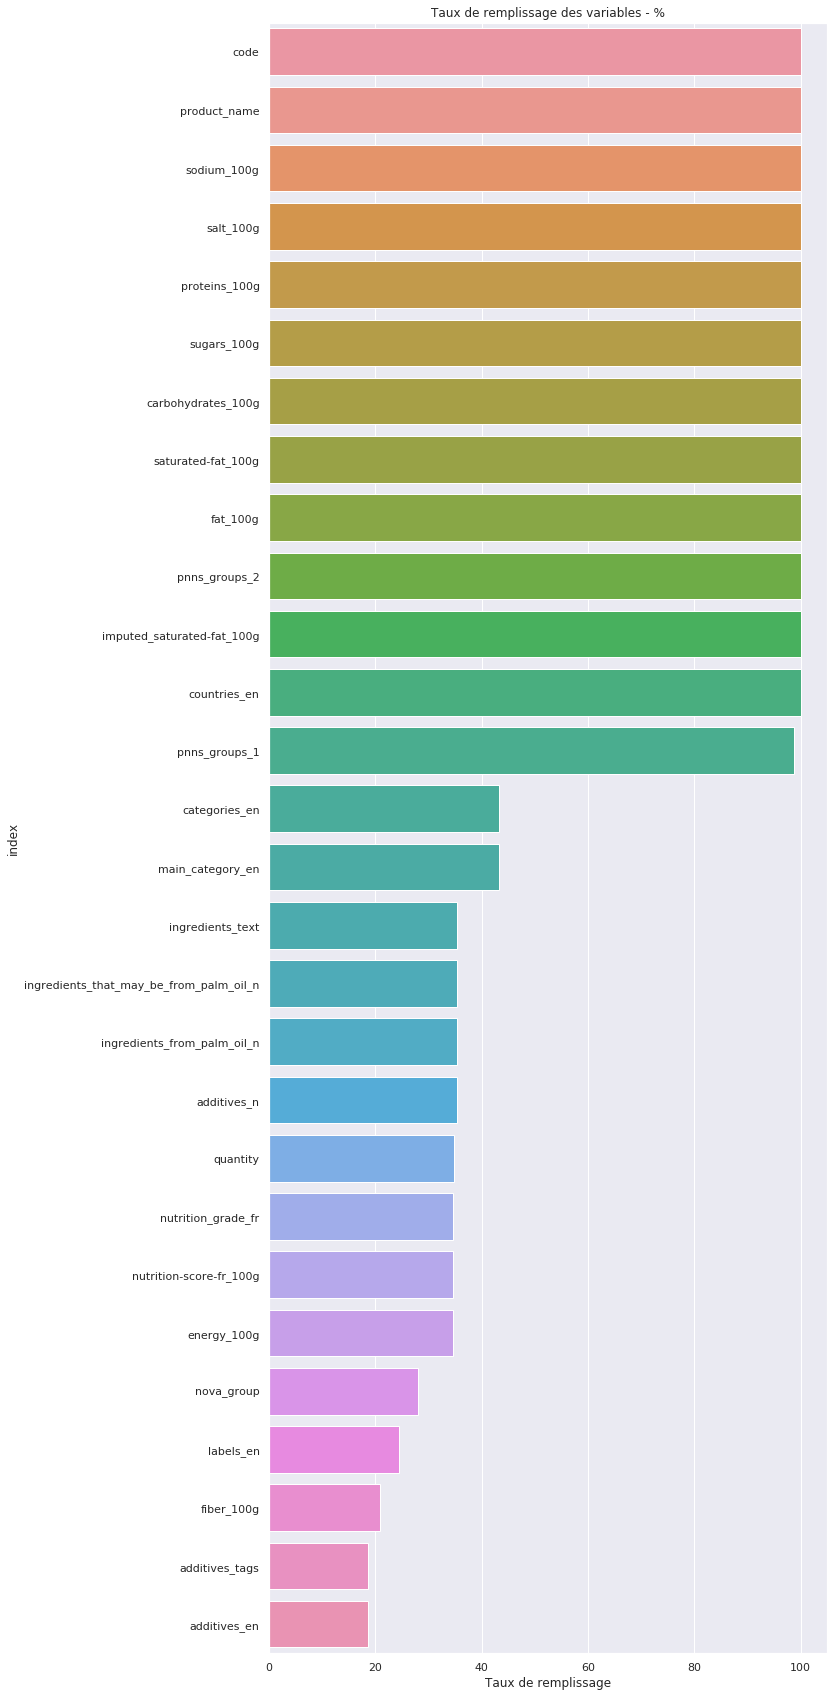

In [0]:
# Calcul du taux de remplissage des colonnes:
df = pd.DataFrame(round(data_cleaned.count(axis=0)/data_cleaned.shape[0]*100,2),
             columns=['Taux de remplissage']).sort_values('Taux de remplissage',
                                                          ascending=False).reset_index()
fig, ax = plt.subplots(figsize=(10,30))
sns.barplot(y=df['index'],
             x='Taux de remplissage',
             data=df,
           )
plt.title('Taux de remplissage des variables - %')
plt.show()

on a réussi a récuperer des valeur sur les nutriment qui vont nous permetre par la suite de calculer le nutriscore

#Calcule du Nutriscore et du nutri grade



In [0]:
data_cleaned.shape

(560301, 28)

In [0]:
# Gestion des NaN pour les nutrition facts: (colonnes avec suffixe _100g):

# Remplacement par des 0 :
L = ['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
     'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g',
     'sodium_100g']
data_cleaned.loc[:,L] = data_cleaned.loc[:,L].fillna(0)

# Suppression s'ils sont tous 0:
data_cleaned = data_cleaned.loc[(data_cleaned.loc[:,L]!=0).any(axis=1)]
data_cleaned.shape

(556356, 28)

##Nutrition score

In [0]:
pnns_groups_2 = data_cleaned['pnns_groups_2'].unique().tolist()
pnns_groups_1 = data_cleaned['pnns_groups_1'].unique().tolist()
print(pnns_groups_2)
print(pnns_groups_1)

['unknown', 'One-dish meals', 'Biscuits and cakes', 'Fruits', 'Meat', 'Cheese', 'Bread', 'Fish and seafood', 'Dairy desserts', 'Fruit juices', 'Legumes', 'Sweetened beverages', 'Unsweetened beverages', 'Sweets', 'Alcoholic beverages', 'Salty and fatty products', 'Dressings and sauces', 'Cereals', 'Appetizers', 'Fats', 'Processed meat', 'pastries', 'Vegetables', 'Breakfast cereals', 'Milk and yogurt', 'Pizza pies and quiche', 'Teas and herbal teas and coffees', 'Sandwiches', 'Potatoes', 'Chocolate products', 'Plant-based milk substitutes', 'Artificially sweetened beverages', 'Nuts', 'Dried fruits', 'vegetables', 'Ice cream', 'Soups', 'Fruit nectars', 'Waters and flavored waters', 'Eggs', 'Offals', 'Pizza pies and quiches', 'fruits', 'cereals', 'legumes', 'nuts']
['Unknown', 'Composite foods', 'Sugary snacks', 'Fruits and vegetables', 'Fish meat eggs', 'Milk and dairy products', 'Cereals and potatoes', 'Beverages', nan, 'Salty snacks', 'Fat and sauces']


In [0]:

data_cleaned['product_name'].unique()


array(['Vitória crackers', 'Cacao', 'Sauce Sweety chili 0%', ...,
       'Taralli Dolci', 'taralli', 'Jambon seche de Dinde'], dtype=object)

In [0]:
data_cleaned['nutrition_grade_fr'].unique()

array([nan, 'b', 'd', 'a', 'c', 'e'], dtype=object)

###Fonction


In [0]:
# Gestion des NaN pour le nutrition_score et nutrition_grade:
# ==> Calcul par la formule d'OpenFoodFacts:
#     (on considère qu'il n'y a pas de données manquantes)

def nutri_calcul(row):
    """Fonction calculant le nutrition_score et nutrition_grade"""
    nutri_grade = ''
    nutri_score = 0    
    
    # Si toutes les valeurs sont NaN:
    x = np.isnan(row['sugars_100g'])
    y = np.isnan(row['energy_100g']) 
    z = np.isnan(row['saturated-fat_100g'])
    w = np.isnan(row['sodium_100g'])
    u = np.isnan(row['fiber_100g'])
    t = np.isnan(row['proteins_100g'])
    if (t & u & w & x & y & z):
        return None,None
    
    # Calcul des points A:
    x = row['sugars_100g']
    b=0
    if (x<=4.5):
        b = 0
    elif (x>4.5) & (x<=9):
        b = 1
    elif (x>9) & (x<=13.5):
        b = 2
    elif (x>13.5) & (x<=18):
        b = 3
    elif (x>18) & (x<=22.5):
        b = 4
    elif (x>22.5) & (x<=27):
        b = 5
    elif (x>27) & (x<=31):
        b = 6
    elif (x>31) & (x<=36):
        b = 7
    elif (x>36) & (x<=40):
        b = 8
    elif (x>40) & (x<=45):
        b = 9
    elif (x>45):
        b = 10   

    x = row['energy_100g']
    a=0
    if (x<=335):
        a = 0
    elif (x>335) & (x<=670):
        a = 1
    elif (x>670) & (x<=1005):
        a = 2
    elif (x>1005) & (x<=1340):
        a = 3
    elif (x>1340) & (x<=1675):
        a = 4
    elif (x>1675) & (x<=2010):
        a = 5
    elif (x>2010) & (x<=2345):
        a = 6
    elif (x>2345) & (x<=2680):
        a = 7
    elif (x>2680) & (x<=3015):
        a = 8
    elif (x>3015) & (x<=3350):
        a = 9
    elif (x>3350):
        a = 10  
        
    x = row['saturated-fat_100g']
    c=0
    if (x<=1):
        c = 0
    elif (x>1) & (x<=2):
        c = 1
    elif (x>2) & (x<=3):
        c = 2
    elif (x>3) & (x<=4):
        c = 3
    elif (x>4) & (x<=5):
        c = 4
    elif (x>5) & (x<=6):
        c = 5
    elif (x>6) & (x<=7):
        c = 6
    elif (x>7) & (x<=8):
        c = 7
    elif (x>8) & (x<=9):
        c = 8
    elif (x>9) & (x<=10):
        c = 9
    elif (x>10):
        c = 10  

    x = row['sodium_100g']
    d=0
    if (x<=0.09):
        d = 0
    elif (x>0.09) & (x<=0.18):
        d = 1
    elif (x>0.18) & (x<=0.27):
        d = 2
    elif (x>0.27) & (x<=0.36):
        d = 3
    elif (x>0.36) & (x<=0.45):
        d = 4
    elif (x>0.45) & (x<=0.54):
        d = 5
    elif (x>0.54) & (x<=0.63):
        d = 6
    elif (x>0.63) & (x<=0.72):
        d = 7
    elif (x>0.72) & (x<=0.81):
        d = 8
    elif (x>0.81) & (x<=0.9):
        d = 9
    elif (x>0.9):
        d = 10  
        
    A = a+b+c+d      
    
    # Calcul des points C:
    x = row['fiber_100g']
    bb=0
    if (x<=0.7):
        bb = 0
    elif (x>0.7) & (x<=1.4):
        bb = 1
    elif (x>1.4) & (x<=2.1):
        bb = 2
    elif (x>2.1) & (x<=2.8):
        bb = 3
    elif (x>2.8) & (x<=3.5):
        bb = 4
    elif (x>3.5):
        bb = 5   
            
    x = row['proteins_100g']
    cc=0
    if (x<=1.6):
        cc = 0
    elif (x>1.6) & (x<=3.2):
        cc = 1
    elif (x>3.2) & (x<=4.8):
        cc = 2
    elif (x>4.8) & (x<=6.4):
        cc = 3
    elif (x>6.4) & (x<=8):
        cc = 4
    elif (x>8):
        cc = 5        
    
    C = bb+cc
    
    #Calcul du nutrition_score:     
    nutri_score = A - C
        
    #Calcul du nutrition_grade:
    if (row['pnns_groups_1']!='Beverages'): #Aliments solides
        if nutri_score<=-1:
            nutri_grade = 'a'
        elif (nutri_score>-1) & (nutri_score<=2):
            nutri_grade = 'b'
        elif (nutri_score>2) & (nutri_score<=10):
            nutri_grade = 'c'
        elif (nutri_score>10) & (nutri_score<=18):
            nutri_grade = 'd'
        elif (nutri_score>18):
            nutri_grade = 'e'
    else:                                   # Boissons
        if (row['product_name']==row['product_name']):
            x = row['product_name'].lower()
            if (('eau' in x) | ('water' in x) | ('agua' in x)): # Eau
                nutri_grade = 'a' 
            elif (nutri_score<1) & (nutri_score<=2):
                nutri_grade = 'b'
            elif (nutri_score>2) & (nutri_score<=5):
                nutri_grade = 'c'
            elif (nutri_score>5) & (nutri_score<=9):
                nutri_grade = 'd'
            elif (nutri_score>9):
                nutri_grade = 'e'
        elif (nutri_score<1) & (nutri_score<=2):
            nutri_grade = 'b'
        elif (nutri_score>2) & (nutri_score<=5):
            nutri_grade = 'c'
        elif (nutri_score>5) & (nutri_score<=9):
            nutri_grade = 'd'
        elif (nutri_score>9):
            nutri_grade = 'e'
   
    return nutri_grade, nutri_score

###Remplacement

In [0]:
# Remplacement des NaN par les valeurs calculés:

flag = data_cleaned.loc[:,'nutrition-score-fr_100g'].count()

df1 = data_cleaned[data_cleaned['nutrition-score-fr_100g'].isna()] 
df2 = df1[df1['pnns_groups_1'].notna()] 
df = df2[df2['pnns_groups_2'].notna()] 

for index, row in df.iterrows():
    nutri_grade, nutri_score = nutri_calcul(row)
    data_cleaned.loc[index,'nutrition-score-fr_100g'] = nutri_score
    try:
      data_cleaned.loc[index,'nutrition_grade_fr'] = nutri_grade
    except:
      pass

print('Nombre de lignes corrigés: ',data_cleaned.loc[:,'nutrition-score-fr_100g'].count()-flag)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [0]:
# Gestion des NaN restants du nutrition_score: 
#  ==> Prédiction du nutrition_score par régression:
#      (pour les lignes ayant pnns_groups_1 ou pnns_groups_2 vides)


df = data_cleaned.loc[:,['nutrition-score-fr_100g','energy_100g','fat_100g',
                 'saturated-fat_100g','carbohydrates_100g','sugars_100g',
                 'fiber_100g','proteins_100g','sodium_100g',
                 'salt_100g']][data_cleaned['nutrition-score-fr_100g'].notnull()]

y = df['nutrition-score-fr_100g'].values
X = df.drop('nutrition-score-fr_100g', axis='columns').values

from sklearn import preprocessing #standardisation
X_scaled = preprocessing.StandardScaler().fit_transform(X)

from sklearn.model_selection import train_test_split #split train test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=33)

from sklearn.ensemble import BaggingRegressor #bootstrapping aggregation method
reg = BaggingRegressor(n_estimators = 100, #decision tree estimator
                       random_state = 33)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

R2 = reg.score(X_test, y_test)
print('Coeff. de détermination: ',round(R2,2))

from sklearn import metrics
RMSE = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),1)
print("RMSE (values in [-15;40]): ",RMSE)

##Nutrition grade

In [0]:

# Gestion des NaN restants du nutrition_grade: 
#  (les lignes ayant pnns_groups_1 ou pnns_groups_2 vides)

# Prédiction du nutrition_grade par classification:
# (on aurait aussi pu le déduire du nutrition_score calculé précedemment par régression)

df = data_cleaned.loc[:,['nutrition_grade_fr','energy_100g','fat_100g',
                 'saturated-fat_100g','carbohydrates_100g','sugars_100g',
                 'fiber_100g','proteins_100g','sodium_100g',
                 'salt_100g']][data_cleaned['nutrition_grade_fr'].notnull()]

from sklearn.preprocessing import LabelEncoder #Transformer données textes en chiffres
labelencoder = LabelEncoder()
df['nutrition_grade_fr'] = labelencoder.fit_transform(df['nutrition_grade_fr'])

y = df['nutrition_grade_fr'].values
X = df.drop('nutrition_grade_fr', axis='columns').values

from sklearn import preprocessing #standardisation
X_scaled = preprocessing.StandardScaler().fit_transform(X)

from sklearn.model_selection import train_test_split #split train test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=33)

from sklearn.ensemble import RandomForestClassifier 
clf = RandomForestClassifier(n_estimators=100,
                             max_depth=20,
                             random_state = 33)
clf.fit(X_train, y_train)
Accuracy = clf.score(X_test, y_test)
print('Accuracy (% valeur correcte): ',round(Accuracy,2))



In [0]:
# Remplacement des NaN par les valeurs prédites:

flag = data_cleaned.loc[:,'nutrition-score-fr_100g'].count()

df = data_cleaned.loc[:,['energy_100g','fat_100g','saturated-fat_100g','carbohydrates_100g','sugars_100g',
                 'fiber_100g','proteins_100g','sodium_100g',
                 'salt_100g']][data_cleaned['nutrition-score-fr_100g'].isna() | data_cleaned['nutrition_grade_fr'].isna()]
X = df.values
score_pred = pd.Series(reg.predict(X), index = df.index)
grade_pred = pd.Series(labelencoder.inverse_transform(clf.predict(X)),index = df.index)

for index, row in df.iterrows():
    if np.isnan(data_cleaned.loc[index,'nutrition-score-fr_100g']):
        data_cleaned.loc[index,'nutrition-score-fr_100g'] = score_pred[index]
    if np.isnan(data_cleaned.loc[index,'nutrition_grade_fr']):
        data_cleaned.loc[index,'nutrition_grade_fr'] = grade_pred[index]

print('Nombre de lignes corrigés: ',data_cleaned.loc[:,'nutrition-score-fr_100g'].count()-flag)

# Étude du remplissage des lignes
Nous allons maintenant étudier le remplissage par produit (ligne).

In [0]:
def rows_fillingrate_histogram(dataframe):
    """This function plots an histogram of the distribution of the 
    filling rate for the rows of a dataframe."""

    # Import libraries
    import matplotlib.ticker as ticker

    # Count the non-null values on each row
    row_count = dataframe.count(axis=1)

    # Calculating filling rates
    nb_columns = dataframe.shape[1]
    filling_rates_row = row_count / nb_columns

    # Plotting histogramm
    fig, ax = plt.subplots(figsize=(20, 10))
    plt.title("Rows' filling rate distribution", fontsize=25)
    plt.xlabel("Filling rate", fontsize=15)
    plt.ylabel("Frequency", fontsize=15)
    ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
    bins = np.linspace(0, 1, num=51)
    ax.hist(filling_rates_row, bins=bins)
    ax.xaxis.set_major_locator(plt.MaxNLocator(11))
    plt.show()

In [0]:
dataframe = data_cleaned
rows_fillingrate_histogram(dataframe)

Nous constatons que les produits (lignes) restant après les nettoyages préliminaires sont au minimum remplis à 38%, et au maximum à 100%.

# Sauvegarde du pd.DataFrame


## Ré-échelonnage de la variable 'nutrition-score-fr_100g'
Le  score  nutritionnel final peut théoriquement  varier  de -15  à  +40  en  fonction  des  produits. Plus il est faible, plus le produit est considéré comme ayant un profil nutritionnel favorable. Source : https://www.anses.fr/fr/system/files/DER2014sa0099Ra.pdf (page 17)

Pour faciliter l'interprétabilité et la lisibilité de la variable, nous allons la transformer en une variable allant de 0 à 100, et telle que 0 représente le pire score et 100 représente le meilleure score de nutrition. Pour cela, nous utilisons la relation :

$$X'= 100 \times\frac{40-X}{55}$$

In [0]:
data_cleaned['nutrition-score-rescale'] = data_cleaned['nutrition-score-fr_100g']

In [0]:
data_cleaned.loc[:,'nutrition-score-rescale'] = 100 * (40 - data_cleaned['nutrition-score-fr_100g']) / 55

## Taux de remplissage final

In [0]:
print("Shape of the cleaned data:", data_cleaned.shape)
filling_rate(data_cleaned)
data_cleaned.info()

In [0]:
#Visualisation du taux de remplissage des colonnes post-nettoyage:

df = pd.DataFrame(round(data_cleaned.count(axis=0)/data_cleaned.shape[0]*100,2),
             columns=['Taux de remplissage']).sort_values('Taux de remplissage',
                                                          ascending=False).reset_index()
fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(y=df['index'],
             x='Taux de remplissage',
             data=df,
           )
plt.title('Taux de remplissage des variables - %')
plt.show()

## Sous-classement des dtytes (*downcast*)
Par défaut, Pandas charge les données en int64 ou en float64. Pour limiter la charge mémoire, il est possible d'essayer de changer le type de données.

In [0]:
data_cleaned.info()

on a envrion 190 MB de données voyont ce que l'on peut faire en effectuant un downcast

In [0]:
import pandas as pd
from typing import List


def optimize_floats(df: pd.DataFrame) -> pd.DataFrame:
    floats = df.select_dtypes(include=['float64']).columns.tolist()
    df[floats] = df[floats].apply(pd.to_numeric, downcast='float')
    return df


def optimize_ints(df: pd.DataFrame) -> pd.DataFrame:
    ints = df.select_dtypes(include=['int64']).columns.tolist()
    df[ints] = df[ints].apply(pd.to_numeric, downcast='integer')
    return df


def optimize_objects(df: pd.DataFrame, datetime_features: List[str]) -> pd.DataFrame:
    for col in df.select_dtypes(include=['object']):
        if col not in datetime_features:
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if float(num_unique_values) / num_total_values < 0.5:
                df[col] = df[col].astype('category')
        else:
            df[col] = pd.to_datetime(df[col])
    return df



def optimize(df: pd.DataFrame, datetime_features: List[str] = []):
    return optimize_floats(optimize_ints(optimize_objects(df, datetime_features)))

In [0]:
optimized_data_cleaned = optimize(data_cleaned)

In [0]:
optimized_data_cleaned.info()

Le resultat et concluant nous avon maintenant une base de données de 90 MB

##Colab

In [0]:
"""from google.colab import files
images_dir = "/content/drive/My Drive/data/OPC03/"
optimized_data_cleaned.to_csv(images_dir + 'data_cleaned.csv', index=False)"""



In [0]:
data_cleaned.describe()